# Imports

In [3]:
# suppress futurewarning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

# imports
import sys, os

import numpy as np
import cv2

#from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

import keras
from keras import layers
from keras.models import Sequential, Model
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Conv2D, Dense
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Flatten
from keras.layers import Input, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Load Dataset

In [7]:
input_path = '../data/samples/'

def load_images_data(img_path):
    (_, _, filenames) = os.walk(input_path).__next__()
    data_array = []
    label_array = []

    for f in filenames:
        img = cv2.imread(img_path + f)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Converting BGR to Grayscale
        img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)  # Converting BGR to RGB
        data_array.append(np.array(img))
        label_array.append(f[0])
    return np.array(data_array), np.array(label_array)


X, y = load_images_data(input_path)

lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_test = X_train / 255.0, X_test / 255.0

print(len(y_train), len(y_test))
print(sum(y_train), sum(y_test))

1033 444
[248] [115]


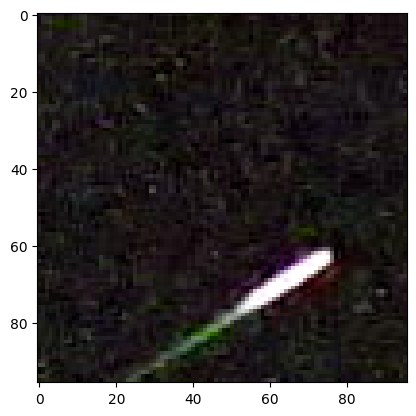

In [9]:
imgpath = '../data/samples/y (217).png'
img = cv2.imread(imgpath)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Converting BGR to Grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB

plt.imshow(img)


# ML Models

In [8]:
#import keras

def build_cnn_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    #model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [9]:
def build_xception_model(input_shape, l2_regularization, num_classes):
    # model parameters/compilation
    # model = mini_XCEPTION(input_shape, num_classes)
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    #output = Activation('softmax',name='predictions')(x) # softmax for multiclass classification
    output = Activation('sigmoid',name='predictions')(x) # sigmoid for binary classifications

    model = Model(img_input, output)
    #model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

# ML Parameters

In [10]:
image_size = (96, 96)
# parameters
batch_size = 32
num_epochs = 10
input_shape = (96, 96, 3)
validation_split = .2
verbose = 1
num_classes = 1
patience = 50
base_path = 'models/'
l2_regularization = 0.01




# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=.2,
                        horizontal_flip=True)

# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]




In [ ]:
xception_model = build_xception_model(input_shape, l2_regularization, num_classes)
xception_model.summary()

# Training

In [ ]:
cnn_model = build_cnn_model(input_shape, num_classes=1)
history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

#history = cnn_model.fit_generator(data_generator.flow(X_train, y_train, batch_size),
#                    steps_per_epoch=len(X_train) / batch_size,
#                    epochs=num_epochs,
#                    verbose=1,
#                    callbacks=callbacks,
#                    validation_data=(X_test, y_test)
#                    )

In [ ]:
history = xception_model.fit_generator(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test)
                    )

# Save Model

In [ ]:
model_path = 'data/gemi_model.hdf5'
m = cnn_model
m.save(model_path)
geminid_model = tf.keras.models.load_model(model_path, custom_objects=None, compile=True)

# Test Model

In [ ]:
m = cnn_model
xp = m.predict(np.array(X_test))
print(np.round(xp))


In [ ]:
ip = 'D:/Geminiden 2021/images3/'

def load_images_data(input_path):
    (_, _, filenames) = os.walk(input_path).__next__()
    data_array = []
    label_array = []

    for f in filenames:
        img = cv2.imread(input_path + f)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Converting BGR to Grayscale
        img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)  # Converting BGR to RGB
        data_array.append(np.array(img))
        label_array.append(f[0])
    return np.array(data_array), np.array(label_array)


X_val, y_val = load_images_data(ip)

lb = preprocessing.LabelBinarizer()
y_val = lb.fit_transform(y_val)

In [ ]:
xp = m.predict(np.array(X_val))
predictedl = np.round(xp)

from sklearn.metrics import accuracy_score


In [ ]:
print(accuracy_score(y_val, predictedl))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)